In [1]:
import os
import sys
import re
import shutil
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


/nfs/student/j/jpierre/anaconda3/envs/tf_gpu_1_5/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nfs/student/j/jpierre/anaconda3/envs/tf_gpu_1_5/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nfs/student/j/jpierre/anaconda3/envs/tf_gpu_1_5/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nfs

In [4]:
drone_database = "drone_set/Database1/"
# filter out image that cant be read
prob_list = ['video17_295','video19_1900'] # cant read format
txt_list = [f for f in os.listdir(drone_database) if f.endswith(".txt") and f[:-4] not in prob_list]
file_list = set([re.match("\w+(?=.)",f)[0] for f in txt_list])# create data list as tuple of (jpeg,txt)
data_list = []
for f in file_list:
    data_list.append((f+".JPEG",f+".txt"))

In [5]:
print(data_list)

[('video17_187.JPEG', 'video17_187.txt'), ('video9129.JPEG', 'video9129.txt'), ('video16_490.JPEG', 'video16_490.txt'), ('video18_2999.JPEG', 'video18_2999.txt'), ('video18_1265.JPEG', 'video18_1265.txt'), ('video16_158.JPEG', 'video16_158.txt'), ('video14_119.JPEG', 'video14_119.txt'), ('video17_1116.JPEG', 'video17_1116.txt'), ('video14_101.JPEG', 'video14_101.txt'), ('video16_643.JPEG', 'video16_643.txt'), ('video17_753.JPEG', 'video17_753.txt'), ('video18_1413.JPEG', 'video18_1413.txt'), ('video9214.JPEG', 'video9214.txt'), ('58.JPEG', '58.txt'), ('video18_1697.JPEG', 'video18_1697.txt'), ('video18_2117.JPEG', 'video18_2117.txt'), ('video17_155.JPEG', 'video17_155.txt'), ('name19.JPEG', 'name19.txt'), ('video16_493.JPEG', 'video16_493.txt'), ('video16_553.JPEG', 'video16_553.txt'), ('video14_134.JPEG', 'video14_134.txt'), ('video14_147.JPEG', 'video14_147.txt'), ('video18_2580.JPEG', 'video18_2580.txt'), ('video19_2495.JPEG', 'video19_2495.txt'), ('video524.JPEG', 'video524.txt'), 

In [7]:
new_dir = os.path.abspath(os.path.join('.', 'annotations_txt'))
pic_dir = os.path.abspath(os.path.join('.', 'images'))
annotations_dir = os.path.abspath(os.path.join('.', 'annotations'))

new_data_list = []
print(new_dir)

with open('trainval.txt', 'w') as trainval:
    for i in range(len(data_list)):
        old_text = os.path.abspath(os.path.join(drone_database, data_list[i][1]))
        old_pic = os.path.abspath(os.path.join(drone_database, data_list[i][0]))
        new_text = os.path.join(new_dir, f"{i+1}"+".txt")
        new_pic = os.path.join(pic_dir, f"{i+1}"+".jpeg")
        shutil.copyfile(old_text, new_text)
        shutil.copyfile(old_pic, new_pic)
        new_data_list.append((new_pic, new_text))
        trainval.write(f'{i+1}\n')
        


/nfs/student/student/j/jpierre/Documents/sandbox/machine_learning/jupyter_notebooks/object_detection/training_models/annotations_txt


In [8]:
X, y = [], []
img_box = []
DIMENSION = 128 # low resolution means less training time

for i in range(len(new_data_list)):
    # get bounding box and check if label exist
    with open(new_data_list[i][1], "rb") as f:
        box = f.read().split()
        if len(box) != 5:
            continue # skip data with no labels

        box = [float(s) for s in box[1:]]
        img = cv2.imread(new_data_list[i][0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # resize image to 128, 128
        img = cv2.resize(img, (DIMENSION, DIMENSION),interpolation=cv2.INTER_LINEAR)
        
        # draw bounding boxes around images
        resize1, resize2 = img.shape[0]/DIMENSION, img.shape[1]/DIMENSION
        p1, p2, p3, p4 = int(box[0]*img.shape[1]*resize2), int(box[1]*img.shape[0]*resize1),int(box[2]*img.shape[1]*resize2), int(box[3]*img.shape[0]*resize1)
        
        ymin, ymax, xmin, xmax = p2-p4//2, p2+p4//2, p1-p3//2, p1+p3//2
        
        draw = cv2.rectangle(img.copy(), (xmax, ymax),(xmin, ymin),color=(255,255,0), thickness=1)
        
        # don't store images with less then 20 pixels
        if ymax  - ymin >= 20:
            X.append(img)
            y.append([ymin, ymax, xmin, xmax])
            img_box.append(draw)
            
            
X = np.array(X).astype(np.uint8)
y = np.array(y)
img_box = np.array(img_box)

            
print(len(X))
print(len(data_list))

693
4008


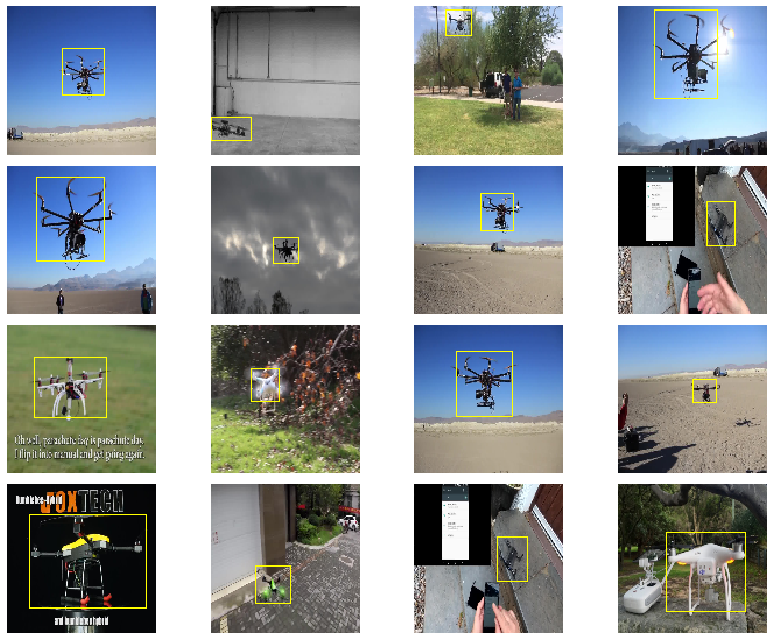

In [9]:
def show_images(img, num_of_imgs=16):
    if len(img) < num_of_imgs:
        print("not enough image to show")
        
        # get 16 images
    plt.figure()
    rows, cols = 4, 4

    for i in range(num_of_imgs):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img[i], cmap='Greys')
#         pred = model.predict(x_test[imi].reshape(1,28,28,1))
#         plt.title(f"pred: {pred.argmax()}\nactual: {y_test_non_categorical[imi]}")
        plt.axis('off')
    plt.tight_layout()
    
show_images(img_box, 16)